In [113]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from scipy.optimize import minimize
from sklearn.cluster import DBSCAN

In [114]:
fits_filex='hlsp_frontier_model_abell2744_williams_v4_x-pixels-deflect.fits'
fits_filey='hlsp_frontier_model_abell2744_williams_v4_y-pixels-deflect.fits'
img_file='hlsp_frontier_model_abell2744_williams_v4_kappa.fits'
mag_file='hlsp_frontier_model_abell2744_williams_v4_z01-magnif.fits'
hdul = fits.open(fits_filex)
hdul1 = fits.open(fits_filey)
hdul_mag = fits.open(mag_file)
hdul_img = fits.open(img_file)

In [115]:
datax = hdul[0].data

datay = hdul1[0].data

data_img = hdul_img[0].data

#array_data = np.zeros((datax.shape[0],datax.shape[1]))
#array_data[100:160, 100:160]=datax[100:160, 100:160]

data_mag = hdul_mag[0].data
hdul.close()
hdul1.close()
hdul_img.close()

32


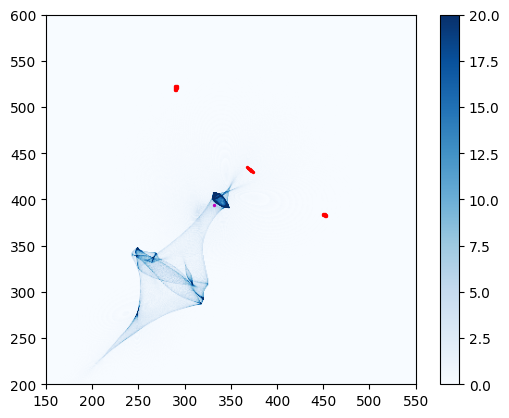

In [116]:
size = datax.shape[0]

array_test = np.zeros((size,size))
img_coord_in_src_coord = [[[] for _ in range(678)] for _ in range(678)]
for i in range(0,678):
    for j in range(0,678):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        #array_test[ceil(ycoord),ceil(xcoord)] += data_img[i,j]*ydec*xdec
        #array_test[ceil(ycoord),floor(xcoord)] += data_img[i,j]*ydec*(1-xdec)
        #array_test[floor(ycoord),ceil(xcoord)] += data_img[i,j]*(1-ydec)*xdec
        array_test[yfloor,xfloor] += data_img[i,j]*(1-ydec)*(1-xdec)
        #img_coord_in_src_coord[floor(ycoord)][floor(xcoord)].append([i,j])

            
# point source            
coord = (332.2,394.4)
def find_rough_def_pix(coord):  
    coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
    y_round, x_round = round(coord[1]), round(coord[0])

    # Pre-calculate possible matching rounded values for efficiency
    y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
    x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

    coordinates = []
    n = 0

    # Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
    for i in range(size):
        for j in range(size):
            ycoord, xcoord = i - datay[i, j], j - datax[i, j]
            if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
                coordinates.append((j, i))  # (x, y)
                n += 1

    #plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=1)
    #plt.scatter(coord[0], coord[1], c='b', s=1)
    
    return coordinates
coordinates = find_rough_def_pix(coord)


plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=2)
plt.scatter(coord[0], coord[1], c='m', s=2)
print(n)

plt.xlim(150,550)
plt.ylim(200,600)
plt.imshow(array_test, cmap='Blues', vmax=20)
plt.colorbar()


Number of pixels: [9, 10, 13]


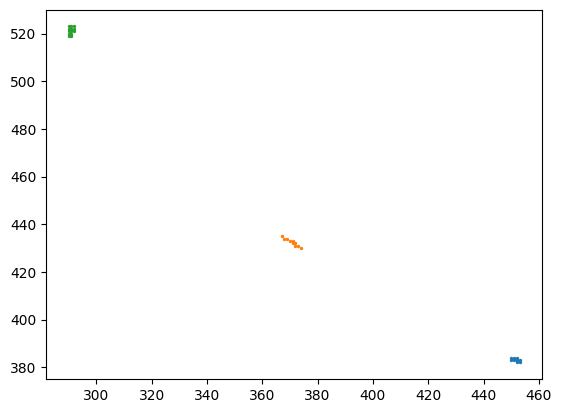

In [117]:
coordinates = np.array(coordinates)

#DBSCAN clustering

dbscan = DBSCAN(eps=3, min_samples=1).fit(coordinates)
labels = dbscan.labels_
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=2)
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')


In [118]:
#checking the vaildity of the source plane map

import matplotlib.pyplot as plt

# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.4, 'center_x': 240, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))
# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape) #(y,x)
alpha_y_2d = alpha_y.reshape(x_grid.shape) #(y,x)



In [119]:
datax = np.array(datax, dtype=np.float64)
datay = np.array(datay, dtype=np.float64)
def def_angle_test_interpolate(x,y, alpha_x= datax, alpha_y = datay):  #(x,y) is img_guess
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array([alpha_x[ceil(y), floor(x)], alpha_y[ceil(y), floor(x)]]) #to match (y,x) of alpha grid
    top_right = np.array([alpha_x[ceil(y), ceil(x)], alpha_y[ceil(y), ceil(x)]])
    bottom_left = np.array([alpha_x[floor(y), floor(x)], alpha_y[floor(y), floor(x)]])
    bottom_right = np.array([alpha_x[floor(y), ceil(x)], alpha_y[floor(y), ceil(x)]])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    alpha = top * dy + bottom *(1 - dy)
    src_guess = np.array([x-alpha[0], y-alpha[1]])
    return src_guess, alpha
                                             
def diff_interpolate (img_guess):
    src_guess = def_angle_test_interpolate(img_guess[0],img_guess[1])[0]
    return np.sqrt((src_guess[0]-coord[0])**2 + (src_guess[1]-coord[1])**2)

450 453 382 384 [451.939483819378 383.889268383841] 1.0591814343753788e-08
367 374 430 435 [371.55992290607  432.398887646216] 8.936676071278089e-09
290 292 519 523 [291.400212949577 522.725972496783] 5.679418329022416e-09


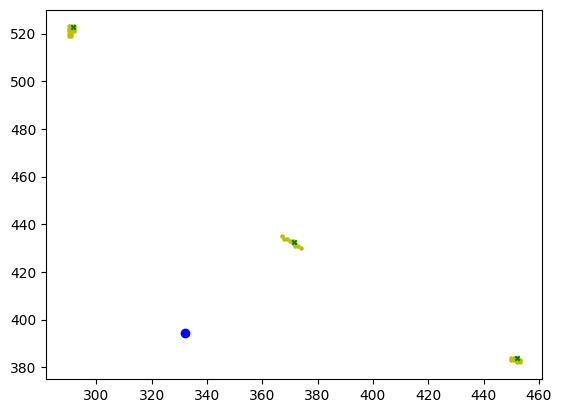

In [130]:
# minimum distance between the source position and the guess source positions deflected by mutiple images
# expect partition of the images and search for 1 sol for 1 image
plt.scatter(coord[0], coord[1], c='b')
plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='y', s=5)
# find maximum x and y coordinates of the image[i]
for i in range(len(images)):
    x_max, x_min = np.max(images[i][:,0]), np.min(images[i][:,0])
    y_max, y_min = np.max(images[i][:,1]), np.min(images[i][:,1])
    img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
    pos = minimize(diff_interpolate, img_guess, bounds =[(x_min-1, x_max+1), (y_min-1, y_max+1)], method='L-BFGS-B', tol=1e-8) # the 1 is for wider boundary
    print(x_min, x_max, y_min, y_max, pos.x, diff_interpolate(pos.x))
    plt.scatter(pos.x[0], pos.x[1], c='g', s=10, marker='x')

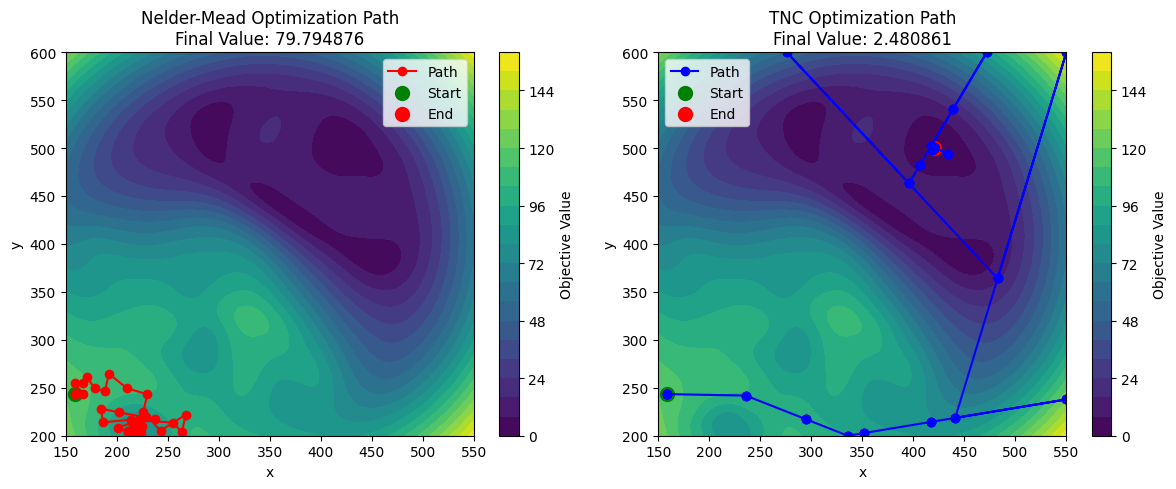

Nelder-Mead result: [220.999979324483 207.000106596255], value: 79.79487643051286
TNC result: [419.999999978034 499.884643119214], value: 2.4808606959828863


In [127]:
def optimize_with_path(method, x0, bounds):
    path = [x0]
    
    def objective_wrapper(x):
        path.append(x)
        return diff_interpolate(x)
    
    result = minimize(objective_wrapper, x0, method=method, bounds=bounds)
    return result, np.array(path)

# Set up the problem
bounds = [(150, 550), (200, 600)]
x0 = np.random.uniform(bounds[0][0], bounds[0][1]), np.random.uniform(bounds[1][0], bounds[1][1])

# Run optimizations
nelder_mead_result, nelder_mead_path = optimize_with_path('Nelder-Mead', x0, bounds)
tnc_result, tnc_path = optimize_with_path('L-BFGS-B', x0, bounds)

# Create a contour plot of the objective function
x = np.linspace(bounds[0][0], bounds[0][1], 100)
y = np.linspace(bounds[1][0], bounds[1][1], 100)
X, Y = np.meshgrid(x, y)
Z = np.array([diff_interpolate([xi, yi]) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

# Plot
plt.figure(figsize=(12, 5))

# Nelder-Mead path
plt.subplot(121)
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Objective Value')
plt.plot(nelder_mead_path[:, 0], nelder_mead_path[:, 1], 'ro-', label='Path')
plt.scatter(nelder_mead_path[0, 0], nelder_mead_path[0, 1], c='g', s=100, label='Start')
plt.scatter(nelder_mead_path[-1, 0], nelder_mead_path[-1, 1], c='r', s=100, label='End')
plt.title(f'Nelder-Mead Optimization Path\nFinal Value: {nelder_mead_result.fun:.6f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# TNC path
plt.subplot(122)
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(label='Objective Value')
plt.plot(tnc_path[:, 0], tnc_path[:, 1], 'bo-', label='Path')
plt.scatter(tnc_path[0, 0], tnc_path[0, 1], c='g', s=100, label='Start')
plt.scatter(tnc_path[-1, 0], tnc_path[-1, 1], c='r', s=100, label='End')
plt.title(f'TNC Optimization Path\nFinal Value: {tnc_result.fun:.6f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()

# Print results
print(f"Nelder-Mead result: {nelder_mead_result.x}, value: {nelder_mead_result.fun}")
print(f"TNC result: {tnc_result.x}, value: {tnc_result.fun}")

In [135]:
# magnification and time delay given source and image positions
image_position = np.array([292.20972079, 424.95360025])

def calculate_magnification(theta, h=1e-9):
    """
    Calculate the magnification at a given image position theta.
    
    :param theta: Image position (2D numpy array)
    :param h: Step size for numerical differentiation
    :return: Magnification
    """
    # Compute partial derivatives

    def partial_derivative(func, var, point): 
        args = point[:]
        def wraps(x):
            args[var] = x
            return func(args)
        return lambda x: (wraps(x+h) - wraps(x-h))/(2*h) # central difference diff fct
    
    def alpha(t):
        alpha = def_angle_test_interpolate(t[0], t[1])[1] #problem: tuple always rounded to few decimal places
        a = float(f"{alpha[0]:.12f}")
        b = float(f"{alpha[1]:.12f}")
        return np.array([a, b])
    
    dalpha1_dtheta1 = partial_derivative(lambda t: alpha(t)[0], 0, theta)(theta[0])
    dalpha1_dtheta2 = partial_derivative(lambda t: alpha(t)[0], 1, theta)(theta[1])
    dalpha2_dtheta1 = partial_derivative(lambda t: alpha(t)[1], 0, theta)(theta[0])
    dalpha2_dtheta2 = partial_derivative(lambda t: alpha(t)[1], 1, theta)(theta[1])
    print(dalpha1_dtheta1, dalpha1_dtheta2, dalpha2_dtheta1, dalpha2_dtheta2)
    # Construct the magnification tensor
    A = np.array([
        [1 - dalpha1_dtheta1, -dalpha1_dtheta2],
        [-dalpha2_dtheta1, 1 - dalpha2_dtheta2]
    ])
    
    # Calculate magnification
    magnification = 1 / np.linalg.det(A)
    
    return magnification

# Example usage

mag = calculate_magnification(image_position)
print(f"Interpolation magnification at {image_position}: {mag}")


1.2274998795192005 -0.2510009977640948 -0.2579980673544924 0.010999201549566351
Interpolation magnification at [292.209720788 424.953600248]: -3.451187535941259
